# Traffic demand generator from a real trace dataset ("cellular_traffic_C2TM.csv")

**ref:** https://arxiv.org/pdf/1804.05186.pdf

**Dataset:** https://github.com/caesar0301/city-cellular-traffic-map

# Preparing the environment

In [1]:
!python -m pip install "git+https://github.com/javadba/mpld3@display_fix"

  Cloning https://github.com/javadba/mpld3 (to revision display_fix) to /tmp/pip-req-build-__3yurpr
  Running command git clone --filter=blob:none --quiet https://github.com/javadba/mpld3 /tmp/pip-req-build-__3yurpr
  Running command git checkout -b display_fix --track origin/display_fix
  Switched to a new branch 'display_fix'
  Branch 'display_fix' set up to track remote branch 'display_fix' from 'origin'.
  Resolved https://github.com/javadba/mpld3 to commit 57ed37dbc4749259b1b46cba8bf28de802972adb
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for mpld3: filename=mpld3-0.3.1.dev1-py3-none-any.whl size=116966 sha256=70c50756a93382e773b06cebc059f9e58f0b4cb1b84d89ba508d205cf80d85ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ljf41c4/wheels/ac/18/7e/22adb40cdaa6b2275ea7b98c395b87929aa3f338e5adf15049
Successfully built mpld3


In [ ]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00


# Demand generator instantiation

In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('cellular_traffic_C2TM.csv')
df = df.sort_values(by='bs')
df = df[df.groupby("bs").bs.transform('count') == 192]
df

Mounted at /content/drive


,bs,time_hour,users,packets,bytes
389417,906,1345467600,2,189,213166.0
1361873,906,1345870800,5,256,254479.0
1209810,906,1345802400,1,2,1570.0
507887,906,1345518000,18,1880,15861267.0
1558800,906,1345964400,8,3245,4421185.0
...,...,...,...,...,...
280956,7999,1345424400,213,31743,49103681.0
1504531,7999,1345939200,169,7810,10148111.0
822305,7999,1345640400,241,20129,93892153.0
1102185,7999,1345759200,116,9608,12882224.0


# Separating data into Day of Week and Weekend

## Day of Week data

In [ ]:
traffic = {}
for bs in df['bs'].unique():
  tmp_df = df.loc[df["bs"] == bs]

  if not tmp_df.empty:
    traffic[bs] = {}

  for index, row in tmp_df.iterrows():
    traffic[bs][row['time_hour']] = row['users']

## Transition function for Day of Week

In [ ]:
# time min 1345305600 - time max 1345993200

ctr_1 = {}

for bs in traffic:
  ctr_1[bs] = {}
  maior = 0
  for tmp in traffic[bs]:
        if traffic[bs][tmp] > maior:
          maior = traffic[bs][tmp]
  for k in traffic[bs]:
      k_tmp = k + 3600

      if k_tmp in traffic[bs]:
        traffic_i = int(100 * (traffic[bs][k]/413))
        traffic_j = int(100 * (traffic[bs][k_tmp]/413))

        si = (bs, datetime.datetime.utcfromtimestamp(k).hour, traffic_i)
        sj = (bs, datetime.datetime.utcfromtimestamp(k_tmp).hour, traffic_j)

        if (si, sj) in ctr_1[bs]:
          ctr_1[bs][(si, sj)] += 1
        else:
          ctr_1[bs][(si, sj)] = 1

p_1 = {}

for bs in ctr_1:
  p_1[bs] = {}
  for c in ctr_1[bs]:
    n = ctr_1[bs][c]
    count = 0
    for c_tmp in ctr_1[bs]:
      if c_tmp[0] == c[0]:
        count += ctr_1[bs][c_tmp]
    p_1[bs][c] = float("{:.2f}".format(n/count))

In [ ]:
# time min 1345305600 - time max 1345993200
topo_df = pd.read_csv('topology.csv')
ctr_1 = {"downtown": {}, "suburb": {}}

for bs in traffic:
  for k in traffic[bs]:
      k_tmp = k + 3600

      if k_tmp in traffic[bs]:
        tmp_topo_df = topo_df.loc[topo_df["bs"] == bs]
        lat = tmp_topo_df["lat"].values[0]
        lon = tmp_topo_df["lon"].values[0]
        if (111.070 < lon < 111.0991) and (13.106  < lat < 13.160):
          bs_type = "downtown"
        else:
          bs_type = "suburb"

        traffic_i = int(100 * (traffic[bs][k]/413))
        traffic_j = int(100 * (traffic[bs][k_tmp]/413))

        si = (datetime.datetime.utcfromtimestamp(k).hour, traffic_i)
        sj = (datetime.datetime.utcfromtimestamp(k_tmp).hour, traffic_j)

        if (si, sj) in ctr_1[bs_type]:
          ctr_1[bs_type][(si, sj)] += 1
        else:
          ctr_1[bs_type][(si, sj)] = 1

p_1 = {}

for bs in ctr_1:
  p_1[bs] = {}
  for c in ctr_1[bs]:
    n = ctr_1[bs][c]
    count = 0
    for c_tmp in ctr_1[bs]:
      if c_tmp[0] == c[0]:
        count += ctr_1[bs][c_tmp]
    p_1[bs][c] = float("{:.2f}".format(n/count))

## Makov Chain for Week Days

In [ ]:
import random

# calculate the traffic to the next k time (i.e, time k+1)
def traffic_generator_p1(bs, k, k_traffic):
  s_i = (bs, k, k_traffic)
  #print(s_i)

  tmp_traffic = []
  traffic_probability = []
  for state in p_1[bs]:
    if state[0] == s_i:
      tmp_traffic.append(state[1][2])
      traffic_probability.append(p_1[bs][state])

  #print(tmp_traffic)

  if traffic_probability:
    synthetic_traffic = random.choices(tmp_traffic, weights=tuple(traffic_probability), k = 1)
    return synthetic_traffic
  else:
    return [-1]

## Implement traffic generator for Week Days

In [ ]:
import random

# calculate the traffic to the next k time (i.e, time k+1)
def traffic_generator_p1(bs, k, k_traffic):
  s_i = (k, k_traffic)
  #print(s_i)
  tmp_topo_df = topo_df.loc[topo_df["bs"] == bs]
  lat = tmp_topo_df["lat"].values[0]
  lon = tmp_topo_df["lon"].values[0]
  if (111.070 < lon < 111.0991) and (13.106  < lat < 13.160):
    bs_type = "downtown"
  else:
    bs_type = "suburb"

  tmp_traffic = []
  traffic_probability = []
  for state in p_1[bs_type]:
    if state[0] == s_i:
      tmp_traffic.append(state[1][1])
      traffic_probability.append(p_1[bs_type][state])

  #print(tmp_traffic)

  if traffic_probability:
    synthetic_traffic = random.choices(tmp_traffic, weights=tuple(traffic_probability), k = 1)
    return synthetic_traffic
  else:
    return [-1]

## Taking Weekend data

In [ ]:
flag = 0
for time in range(1345316400, 1345316400+(24*3600), 3600):
  for bs in df['bs'].unique():
    tmp_df = df.loc[df["bs"] == bs]

    if not tmp_df.empty:
      tmp_df.drop(tmp_df.loc[tmp_df['time_hour'] != time].index, inplace=True)
      if flag == 0:
        df_fds_1 = tmp_df
        flag = 1
      else:
        df_fds_1 = pd.concat([df_fds_1, tmp_df])

df_fds_1

Streaming output truncated to the last 5000 lines.
<ipython-input-10-a84edf60dd70>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.drop(tmp_df.loc[tmp_df['time_hour'] != time].index, inplace=True)
<ipython-input-10-a84edf60dd70>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.drop(tmp_df.loc[tmp_df['time_hour'] != time].index, inplace=True)
<ipython-input-10-a84edf60dd70>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

,bs,time_hour,users,packets,bytes
23030,906,1345316400,1,37,42955.0
22436,1948,1345316400,1,1,217.0
26104,2351,1345316400,5,1015,1133265.0
25703,2355,1345316400,4,107,97996.0
23481,2477,1345316400,1,337,486229.0
...,...,...,...,...,...
225940,7995,1345399200,70,10083,12632692.0
225938,7996,1345399200,64,11549,31291331.0
225943,7997,1345399200,82,12051,15953133.0
225941,7998,1345399200,74,25833,148061170.0


In [ ]:
flag = 0
for time in range(1345834800, 1345834800+(3600*24), 3600):
  for bs in df['bs'].unique():
    tmp_df = df.loc[df["bs"] == bs]

    if not tmp_df.empty:
      tmp_df.drop(tmp_df.loc[tmp_df['time_hour'] != time].index, inplace=True)
      if flag == 0:
        df_fds_2 = tmp_df
        flag = 1
      else:
        df_fds_2 = pd.concat([df_fds_2, tmp_df])

df_fds_2

Streaming output truncated to the last 5000 lines.
<ipython-input-11-ee9dd864337f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.drop(tmp_df.loc[tmp_df['time_hour'] != time].index, inplace=True)
<ipython-input-11-ee9dd864337f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.drop(tmp_df.loc[tmp_df['time_hour'] != time].index, inplace=True)
<ipython-input-11-ee9dd864337f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

,bs,time_hour,users,packets,bytes
1289462,906,1345834800,4,93,109148.0
1288728,1948,1345834800,3,199,232462.0
1287189,2351,1345834800,1,283,578000.0
1289072,2355,1345834800,3,805,1204174.0
1287473,2477,1345834800,1,20,29001.0
...,...,...,...,...,...
1466348,7995,1345917600,74,15759,18797112.0
1466346,7996,1345917600,59,13933,17644440.0
1466351,7997,1345917600,82,10183,22327314.0
1466349,7998,1345917600,76,9082,26138788.0


In [ ]:
df_fds = pd.concat([df_fds_1, df_fds_2])

In [ ]:
traffic = {}
for bs in df_fds['bs'].unique():
  tmp_df = df_fds.loc[df_fds["bs"] == bs]

  if not tmp_df.empty:
    traffic[bs] = {}

  for index, row in tmp_df.iterrows():
    traffic[bs][row['time_hour']] = row['users']

In [ ]:
# time min 1345305600 - time max 1345993200

ctr_2 = {}

for bs in traffic:
  ctr_2[bs] = {}
  maior = 0
  for tmp in traffic[bs]:
        if traffic[bs][tmp] > maior:
          maior = traffic[bs][tmp]
  for k in traffic[bs]:
      k_tmp = k + 3600

      if k_tmp in traffic[bs]:
        traffic_i = int(100 * (traffic[bs][k]/413))
        traffic_j = int(100 * (traffic[bs][k_tmp]/413))

        si = (bs, datetime.datetime.utcfromtimestamp(k).hour, traffic_i)
        sj = (bs, datetime.datetime.utcfromtimestamp(k_tmp).hour, traffic_j)

        if (si, sj) in ctr_2[bs]:
          ctr_2[bs][(si, sj)] += 1
        else:
          ctr_2[bs][(si, sj)] = 1

p_2 = {}

for bs in ctr_2:
  p_2[bs] = {}
  for c in ctr_2[bs]:
    n = ctr_2[bs][c]
    count = 0
    for c_tmp in ctr_2[bs]:
      if c_tmp[0] == c[0]:
        count += ctr_2[bs][c_tmp]
    p_2[bs][c] = float("{:.2f}".format(n/count))

In [1]:
# time min 1345305600 - time max 1345993200
topo_df = pd.read_csv('topology.csv')
ctr_2 = {"downtown": {}, "suburb": {}}

for bs in traffic:
  for k in traffic[bs]:
      k_tmp = k + 3600

      if k_tmp in traffic[bs]:
        tmp_topo_df = topo_df.loc[topo_df["bs"] == bs]
        lat = tmp_topo_df["lat"].values[0]
        lon = tmp_topo_df["lon"].values[0]
        if (111.070 < lon < 111.0991) and (13.106  < lat < 13.160):
          bs_type = "downtown"
        else:
          bs_type = "suburb"

        traffic_i = int(100 * (traffic[bs][k]/413))
        traffic_j = int(100 * (traffic[bs][k_tmp]/413))

        si = (datetime.datetime.utcfromtimestamp(k).hour, traffic_i)
        sj = (datetime.datetime.utcfromtimestamp(k_tmp).hour, traffic_j)

        if (si, sj) in ctr_2[bs_type]:
          ctr_2[bs_type][(si, sj)] += 1
        else:
          ctr_2[bs_type][(si, sj)] = 1

p_2 = {}

for bs in ctr_2:
  p_2[bs] = {}
  for c in ctr_2[bs]:
    n = ctr_2[bs][c]
    count = 0
    for c_tmp in ctr_2[bs]:
      if c_tmp[0] == c[0]:
        count += ctr_2[bs][c_tmp]
    p_2[bs][c] = float("{:.2f}".format(n/count))

NameError: name 'pd' is not defined

In [ ]:
import random

def traffic_generator_p2(bs, k, k_traffic):
  s_i = (k, k_traffic)
  tmp_topo_df = topo_df.loc[topo_df["bs"] == bs]
  lat = tmp_topo_df["lat"].values[0]
  lon = tmp_topo_df["lon"].values[0]
  if (111.070 < lon < 111.0991) and (13.106  < lat < 13.160):
    bs_type = "downtown"
  else:
    bs_type = "suburb"

  tmp_traffic = []
  traffic_probability = []
  for state in p_2[bs_type]:
    if state[0] == s_i:
      tmp_traffic.append(state[1][1])
      traffic_probability.append(p_2[bs_type][state])

  if traffic_probability:
    synthetic_traffic = random.choices(tmp_traffic, weights=tuple(traffic_probability), k = 1)
    return synthetic_traffic
  else:
    return [-1]

## Generating synthetic data for a complete week


In [ ]:
syn_traffic = {}
all_days_traffic = {}

for day in range(1, 9):
  all_days_traffic[day] = {}

  for new_bs in df['bs'].unique():
    syn_traffic[new_bs] = []

    tmp_topo_df = topo_df.loc[topo_df["bs"] == new_bs]
    lat = tmp_topo_df["lat"].values[0]
    lon = tmp_topo_df["lon"].values[0]
    if (111.070 < lon < 111.0991) and (13.106  < lat < 13.160):
      bs_type = "centro"
    else:
      bs_type = "bairro"
    maior = 0
    if(1 < day < 7):
      for k in ctr_1[bs_type]:
        if k[0][0] == 16 and ctr_1[bs_type][k] >= maior:
          maior = ctr_1[bs_type][k]
          si = k[0]
    else:
      for k in ctr_2[bs_type]:
        if k[0][0] == 19 and ctr_2[bs_type][k] > maior:
          maior = ctr_2[bs_type][k]
          si = k[0]

    # print(syn_traffic, new_bs, si)
    syn_traffic[new_bs].append(si[1])

    hour = 16

    while hour < 24:
      if(1 < day < 7):
        s_j = traffic_generator_p1(new_bs, hour, syn_traffic[new_bs][hour - 16])

      else:
        if hour + 3 <= 23:
          tmp_hour = hour + 3
          s_j = traffic_generator_p2(new_bs, tmp_hour, syn_traffic[new_bs][hour - 16])
        else:
          tmp_hour = hour - 21
          s_j = traffic_generator_p2(new_bs, tmp_hour, syn_traffic[new_bs][hour - 16])
      if s_j[0] >= 0:
        hour += 1
        syn_traffic[new_bs].append(s_j[0])
      else:
        break

    hour = 0

    while hour < 15:
      if(1 < day < 7):
        s_j = traffic_generator_p1(new_bs, hour, syn_traffic[new_bs][hour + 8])
      else:
        tmp_hour = hour + 3
        s_j = traffic_generator_p2(new_bs, tmp_hour, syn_traffic[new_bs][hour + 8])
      if s_j[0] >= 0:
        hour += 1
        syn_traffic[new_bs].append(s_j[0])
      else:
        break

    all_days_traffic[day][new_bs] = syn_traffic[new_bs]

In [ ]:
# time min 1345305600 - time max 1345993200

count = 0
for bs in df['bs'].unique():
  p_BS = [bs for i in range(0, 192)]
  hour = []
  for i in range(1345305600, 1345993201, 3600):
      hour.append(i)

  bs_all_time = []

  for day in all_days_traffic:
    for i in all_days_traffic[day][bs]:
      bs_all_time.append(i)

  data = {"bs": p_BS, "time_hour": hour, "users": bs_all_time}

  if count == 0:
    syn_df = pd.DataFrame(data)
    count += 1
  else:
    tmp_syn_df = pd.DataFrame(data)
    syn_df = pd.concat([syn_df, tmp_syn_df])

syn_df

,bs,time_hour,users
0,906,1345305600,0
1,906,1345309200,0
2,906,1345312800,1
3,906,1345316400,2
4,906,1345320000,4
...,...,...,...
187,7999,1345978800,2
188,7999,1345982400,2
189,7999,1345986000,2
190,7999,1345989600,1


In [ ]:
 syn_df.to_csv("syn_df.csv")

380736

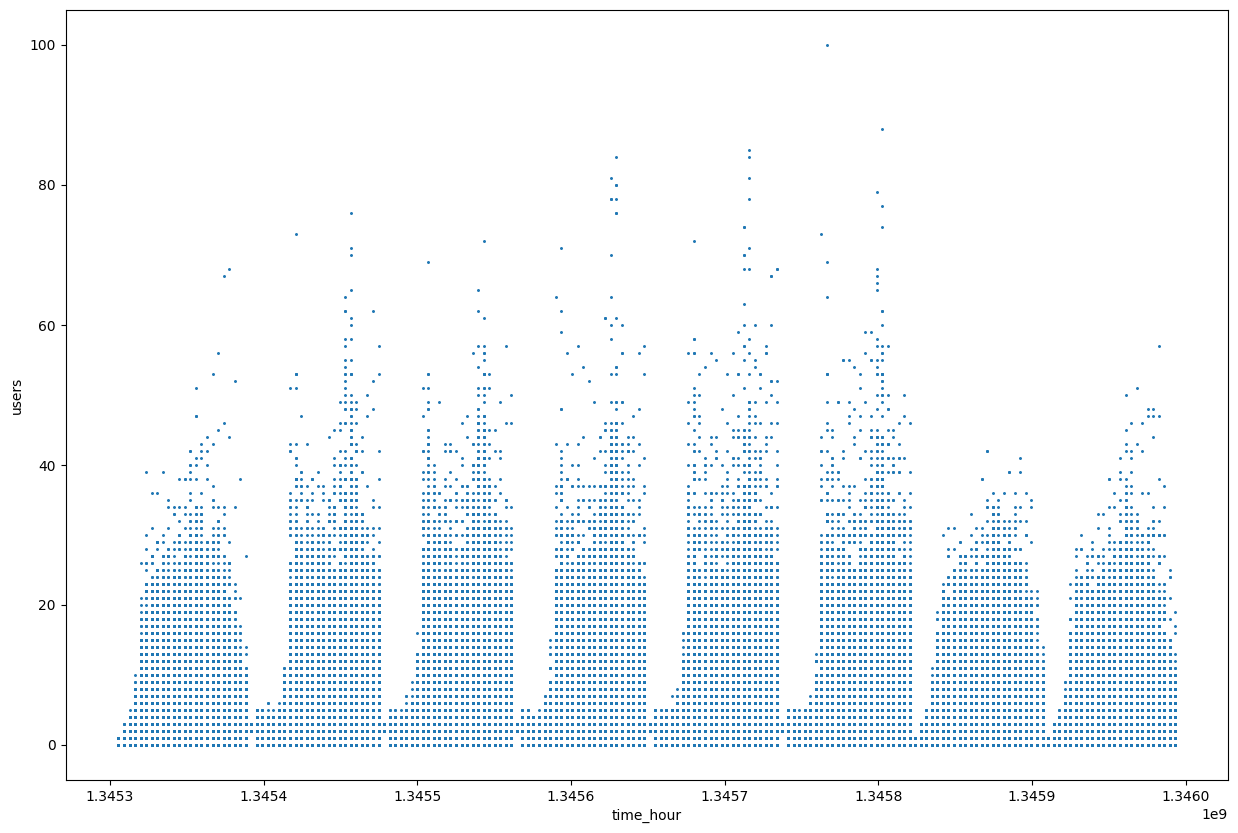

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
syn_df.plot.scatter(x = 'time_hour', y = 'users', s=1.3)
df["users"].shape[0]

In [2]:
!python -m pip uninstall matplotlib -y
!pip install matplotlib==3.1.3
plt.rcParams["figure.figsize"] = (15, 10)
df.plot.scatter(x = 'time_hour', y = 'users', s=1)
df["users"].shape[0]

/bin/bash: line 1: python: command not found


Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.1.3.tar.gz (40.9 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp310-cp310-linux_x86_64.whl size=11757588 sha256=2a457216d1ef3b093df3b2f0a41c40aac6988f77b6d4d2a9e56673b0e16a27ad
  Stored in directory: /home/gabriel/.cache/pip/wheels/a7/83/5a/c704868d367ace343ac89b928f3d937313a5b5fb5731483705
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.2
    Uninstalling matplotlib-3.9.2:
      Successfully uninstalled matplotlib-3.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipympl 0.9.4 requires matplotlib<4,>=3.4.0, but you have matplotlib 3.1.3 which is incompatible.


NameError: name 'plt' is not defined

# Analisando o posicionamento das BSs

In [ ]:
drive.mount('/content/drive')
topo_df = pd.read_csv('/content/drive/My Drive/Dissertacao_Gabriel/BS_traffic_load_datasets/topology.csv')

# ordenando o dataset por base station
topo_df = topo_df.sort_values(by='bs')

topo_df

In [ ]:
syn_loc_dict = {"bs": [], "lon": [], "lat": []}
for bs in syn_df['bs'].unique():
  tmp_loc = topo_df[topo_df["bs"] == bs]
  syn_loc_dict['bs'].append(bs)
  syn_loc_dict['lat'].append(tmp_loc['lat'].values[0])
  syn_loc_dict['lon'].append(tmp_loc['lon'].values[0])

print(syn_loc_dict)

In [ ]:
syn_loc = pd.DataFrame(syn_loc_dict)
syn_loc = syn_loc.drop_duplicates()
syn_loc

# Topologia dos dados sintéticos

## Calculando variância e taxa de variação (max - min)

In [ ]:
# Variância
user_dif = {}

for bs in syn_loc['bs']:
  tmp_syn = syn_df[syn_df["bs"] == bs]
  user_dif[bs] = tmp_syn["users"].var()

print(user_dif)

In [ ]:
# Diferença
user_dif = {}

for bs in syn_loc['bs']:
  user_dif[bs] = syn_df[syn_df['bs'] == bs]['users'].max() - syn_df[syn_df['bs'] == bs]['users'].min()

print(user_dif)

In [ ]:
!pip install ipympl

In [ ]:
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

## Variância

In [ ]:
import plotly.express as px

for bs in syn_loc['bs']:
  tmp_df = syn_loc.loc[syn_loc['bs'] == bs]

fig = px.scatter(x=syn_loc['lon'], y=syn_loc['lat'], color = list(user_dif.values()), width=1000, height=700)
fig.show()

## Taxa de variação (max - min)

In [ ]:
import plotly.express as px

for bs in syn_loc['bs']:
  tmp_df = syn_loc.loc[syn_loc['bs'] == bs]

fig = px.scatter(x=syn_loc['lon'], y=syn_loc['lat'], color = list(user_dif.values()), width=1000, height=700)
fig.show()

# Separando BSs por região de acordo com a diferença de usuários

## Centro - maior diferença

### Separando o Dataset

In [ ]:
center_bs = []
for bs in syn_loc["bs"]:
  tmp_syn = syn_loc[syn_loc["bs"] == bs]
  lat = tmp_syn["lat"].values[0]
  lon = tmp_syn["lon"].values[0]
  if (111.070 < lon < 111.0991) and (13.106  < lat < 13.160):
    center_bs.append(tmp_syn["bs"].values[0])

print("Centro possui {} BSs".format(len(center_bs)))
print(center_bs)

In [ ]:
center_df_loc = pd.DataFrame()
for bs in center_bs:
  tmp_syn = syn_loc[syn_loc["bs"] == bs]
  center_df_loc = pd.concat([center_df_loc, tmp_syn])

In [ ]:
center_df = pd.DataFrame()
for bs in center_bs:
  tmp_syn = syn_df[syn_df["bs"] == bs]
  center_df = pd.concat([center_df, tmp_syn])

In [ ]:
# Diferença
user_dif = {}

for bs in center_df_loc['bs']:
  user_dif[bs] = center_df[center_df['bs'] == bs]['users'].max() - center_df[center_df['bs'] == bs]['users'].min()

print(user_dif)

### Plotando região de acordo com a diferença e o consumo de cada BS

In [ ]:
import plotly.express as px

for bs in center_df_loc['bs']:
  tmp_df = center_df_loc.loc[syn_loc['bs'] == bs]

fig = px.scatter(x=center_df_loc['lon'], y=center_df_loc['lat'], color = list(user_dif.values()), width=1000, height=700)
fig.show()

In [ ]:
pd.options.plotting.backend = "plotly"
center_df["users"].plot.line()

In [ ]:
center_df_loc

In [ ]:
core_pos = (13.133056, 111.085)

# Adicionando o Core no ponto central da região e calculando a distância de Manhattan (90º) de toda BS para o Core

In [ ]:
core_loc = {"bs": "0", "lon": "111.085", "lat": "13.133056"}
center_df_loc = center_df_loc.append(core_loc, ignore_index = True)

In [ ]:
from geopy.distance import geodesic

core_dist = []

for bs in center_df_loc['bs']:
  if bs != '0':
    tmp_df = center_df_loc.loc[center_df_loc['bs'] == bs]
    origin = (13.133056, 111.085) # Core (lat, lon)
    loc = (tmp_df["lat"].item(), 111.085)
    d1 = geodesic(origin, loc).kilometers

    loc = (13.133056, tmp_df["lon"].item())
    d2 = geodesic(origin, loc).kilometers

    core_dist.append(round(d1 + d2, 2))

  else:
    core_dist.append(0)

center_df_loc["core_dist"] = core_dist

center_df_loc

,bs,lon,lat,core_dist
0,2477,111.080426,13.110332,3.01
1,3139,111.0903,13.143237,1.70
2,3211,111.072889,13.119499,2.81
3,3416,111.085493,13.139268,0.74
4,3522,111.074863,13.131037,1.32
...,...,...,...,...
496,7995,111.084888,13.110019,2.56
497,7996,111.090853,13.115747,2.55
498,7997,111.084914,13.112035,2.33
499,7999,111.086408,13.11118,2.57


In [ ]:
px.scatter(x=[i for i in range(0, 501)], y=center_df_loc['core_dist'].sort_values())

# Gerando um grafo teórico a partir da topologia

### Algoritmo que levava em consideração a distribuição em camadas do PASSION

In [ ]:
# PASSION distribution -- HL3 = 1.2% (pelo menos 2) | HL4 = 13.4% (pelo menos 2) | HL5 = 85.4% (pelo menos 1)
from geopy import distance
import math

final_graph = [1, 1]
number_of_nodes = 30
radius = 0.5
n = {}

while(len(final_graph) != len(set(final_graph))):
  print("Calculating a new graph")

  graph = []
  links = []
  hl3 = []
  hl4 = []

  # Iniciando a partir do Core
  tmp_df = center_df_loc.loc[center_df_loc['bs'] == '0']
  init_lat = float(tmp_df["lat"].item())
  init_lon = float(tmp_df["lon"].item())

  # Escolhendo HL3

  h = 2
  if math.ceil((number_of_nodes*1.2)/100) > 2:
    h = math.ceil((number_of_nodes*1.2)/100)

  covered_bs = []
  p = []
  for bs in center_df_loc["bs"]:
    if bs != '0':
      tmp_df = center_df_loc.loc[center_df_loc['bs'] == bs]
      bs_lat = float(tmp_df['lat'].item())
      bs_lon = float(tmp_df['lon'].item())
      dis = distance.distance((init_lat, init_lon), (bs_lat, bs_lon)).km
      if dis <= radius and bs not in covered_bs:
        covered_bs.append(bs)
        p.append(user_dif[bs])

  print("HL3", h, len(covered_bs))
  new_v = random.sample(covered_bs, k=h)

  for i in new_v:
    graph.append(i)
    hl3.append(i)
    links.append((0, i))

  # Escolhendo HL4

  h = 2
  if math.ceil((number_of_nodes*13.4)/100) > 2:
    h = math.ceil((number_of_nodes*13.4)/100)

  covered_bs = []
  p = []

  for i in range(0, len(hl3) - 1):
    cr1 = hl3[i]
    cr2 = hl3[i + 1]

    tmp_df = center_df_loc.loc[center_df_loc['bs'] == cr1]
    lat_cr1 = float(tmp_df["lat"].item())
    lon_cr1 = float(tmp_df["lon"].item())

    tmp_df = center_df_loc.loc[center_df_loc['bs'] == cr2]
    lat_cr2 = float(tmp_df["lat"].item())
    lon_cr2 = float(tmp_df["lon"].item())

    for bs in center_df_loc["bs"]:
      if bs != '0':
        tmp_df = center_df_loc.loc[center_df_loc['bs'] == bs]
        bs_lat = float(tmp_df['lat'].item())
        bs_lon = float(tmp_df['lon'].item())
        dis1 = distance.distance((lat_cr1, lon_cr1), (bs_lat, bs_lon)).km
        dis2 = distance.distance((lat_cr2, lon_cr2), (bs_lat, bs_lon)).km
        if dis1 <= radius and dis2 <= radius and bs not in covered_bs:
          covered_bs.append(bs)
          p.append(user_dif[bs])
          n[bs] = [cr1, cr2]

  for c in hl3:
    if c in covered_bs:
      covered_bs.remove(c)

  print("HL4", h, len(covered_bs))
  new_v = random.sample(covered_bs, k=h)

  for i in new_v:
    graph.append(i)
    hl4.append(i)
    links.append((n[i][0], i))
    links.append((n[i][1], i))

  # Escolhendo HL5

  h = 1
  if math.floor((number_of_nodes*85.4)/100) > 1:
    h = math.floor((number_of_nodes*85.4)/100) - 2

  covered_bs = []
  p = []

  for i in range(0, len(hl4) - 1):
    cr1 = hl4[i]
    cr2 = hl4[i + 1]

    tmp_df = center_df_loc.loc[center_df_loc['bs'] == cr1]
    lat_cr1 = float(tmp_df["lat"].item())
    lon_cr1 = float(tmp_df["lon"].item())

    tmp_df = center_df_loc.loc[center_df_loc['bs'] == cr2]
    lat_cr2 = float(tmp_df["lat"].item())
    lon_cr2 = float(tmp_df["lon"].item())

    for bs in center_df_loc["bs"]:
      if bs != '0':
        tmp_df = center_df_loc.loc[center_df_loc['bs'] == bs]
        bs_lat = float(tmp_df['lat'].item())
        bs_lon = float(tmp_df['lon'].item())
        dis1 = distance.distance((lat_cr1, lon_cr1), (bs_lat, bs_lon)).km
        dis2 = distance.distance((lat_cr2, lon_cr2), (bs_lat, bs_lon)).km
        if dis1 <= radius and dis2 <= radius and bs not in covered_bs:
          covered_bs.append(bs)
          p.append(user_dif[bs])
          n[bs] = [cr1, cr2]


  for c in hl3:
    if c in covered_bs:
      covered_bs.remove(c)
  for c in hl4:
    if c in covered_bs:
      covered_bs.remove(c)

  print("HL5", h, len(covered_bs))
  new_v = random.sample(covered_bs, k=h)

  for i in new_v:
    graph.append(i)
    links.append((n[i][0], i))
    links.append((n[i][1], i))

  final_graph = graph

  print(graph)
  print(links)

# for i in new_v:
#     graph.append(i)
#     for c in hl4:
#       tmp_df = center_df_loc.loc[center_df_loc['bs'] == c]
#       lat_c = float(tmp_df["lat"].item())
#       lon_c = float(tmp_df["lon"].item())

#       tmp_df = center_df_loc.loc[center_df_loc['bs'] == i]
#       lat_i = float(tmp_df["lat"].item())
#       lon_i = float(tmp_df["lon"].item())

#       dis = distance.distance((lat_c, lon_c), (lat_i, lon_i)).km
#       if dis <= radius:
#         links.append((c, i))
#         links.append((c, i))

Calculating a new graph
HL3 2 34
HL4 5 10


KeyboardInterrupt: ignored

### Novo algoritmo sem proporção em camadas (aleatório)

### Novo algoritmo sem proporção em camadas (ordenado por distância)

In [ ]:
from geopy import distance
import math

flag = 0

while flag == 0:

  number_of_nodes = 32
  core_links = 2
  radius = 0.5

  count_nodes = 0
  n = {}

  graph = []
  links = []
  link_layer = {}
  layer = {0: 0}
  candidates = []

  # Iniciando a partir do Core
  tmp_df = center_df_loc.loc[center_df_loc['bs'] == '0']
  init_lat = float(tmp_df["lat"].item())
  init_lon = float(tmp_df["lon"].item())
  init_bs = 0
  c = {}
  c[0] = 0
  layer_count = 0

  while count_nodes < number_of_nodes:
    print("init", len(graph), init_bs)

    ################ searching nodes from Core ################
    if layer_count == 0:
      layer_count = 1
      for bs in center_df_loc["bs"]:
        if bs != '0':
          tmp_df = center_df_loc.loc[center_df_loc['bs'] == bs]
          bs_lat = float(tmp_df['lat'].item())
          bs_lon = float(tmp_df['lon'].item())
          dis = distance.distance((init_lat, init_lon), (bs_lat, bs_lon)).km
          if dis <= radius/2 and bs not in graph:
            if count_nodes < number_of_nodes and bs not in candidates and c[init_bs] < core_links and bool(random.getrandbits(1)):
              graph.append(bs)
              c[init_bs] += 1
              count_nodes += 1
              links.append((init_bs, bs))
              layer[bs] = layer[init_bs] + 1

            candidates.append(bs)

    ################ searching nodes from first layer ################
    if layer_count == 1:
      layer_count = 2
      for init_bs in graph:
        tmp_df = center_df_loc.loc[center_df_loc['bs'] == init_bs]
        init_lat = float(tmp_df["lat"].item())
        init_lon = float(tmp_df["lon"].item())
        if init_bs not in c:
            c[init_bs] = 0

        for bs in center_df_loc["bs"]:
          if bs != '0':
            tmp_df = center_df_loc.loc[center_df_loc['bs'] == bs]
            bs_lat = float(tmp_df['lat'].item())
            bs_lon = float(tmp_df['lon'].item())
            dis = distance.distance((init_lat, init_lon), (bs_lat, bs_lon)).km
            if dis <= radius and bs not in graph:
              if c[init_bs] == 0 and count_nodes < number_of_nodes: # and bs not in candidates:
                graph.append(bs)
                c[init_bs] += 1
                count_nodes += 1
                links.append((init_bs, bs))
                layer[bs] = layer[init_bs] + 1

              elif bool(random.getrandbits(1)) and count_nodes < number_of_nodes and c[init_bs] < 3 and bs not in candidates:
                graph.append(bs)
                c[init_bs] += 1
                count_nodes += 1
                links.append((init_bs, bs))
                layer[bs] = layer[init_bs] + 1

              candidates.append(bs)

    ################ searching nodes from others layers ################
    if layer_count == 2:
      init_bs = graph.pop(0)
      graph.append(init_bs)
      tmp_df = center_df_loc.loc[center_df_loc['bs'] == init_bs]
      init_lat = float(tmp_df["lat"].item())
      init_lon = float(tmp_df["lon"].item())

      if init_bs not in c:
        c[init_bs] = 0

      for bs in center_df_loc["bs"]:
        if bs != '0':
          tmp_df = center_df_loc.loc[center_df_loc['bs'] == bs]
          bs_lat = float(tmp_df['lat'].item())
          bs_lon = float(tmp_df['lon'].item())
          dis = distance.distance((init_lat, init_lon), (bs_lat, bs_lon)).km
          if dis <= radius and bs not in graph:
            if bool(random.getrandbits(1)) and count_nodes < number_of_nodes and c[init_bs] < 3 and bs not in candidates:
              graph.append(bs)
              c[init_bs] += 1
              count_nodes += 1
              links.append((init_bs, bs))
              layer[bs] = layer[init_bs] + 1

            candidates.append(bs)
    # print(graph)
    # print(layer)

  #### add alternative links

  for bs1 in layer:
    distances = {}

    if layer[bs1] > 1:
      tmp_df1 = center_df_loc.loc[center_df_loc['bs'] == bs1]
      init_lat = float(tmp_df1["lat"].item())
      init_lon = float(tmp_df1["lon"].item())
      init_bs = bs1
      d = 1

      for bs in graph:
        if layer[bs] == layer[init_bs] - 1:
          tmp_df2 = center_df_loc.loc[center_df_loc['bs'] == bs]
          bs_lat = float(tmp_df2['lat'].item())
          bs_lon = float(tmp_df2['lon'].item())
          dis = distance.distance((init_lat, init_lon), (bs_lat, bs_lon)).km
          if dis <= 1 and c[bs] < 3 and (bs, init_bs) not in links:
            distances[bs] = dis

      ####### sort BSs by distance ########
      sort_distances = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1])}
      # print("sorted", sort_distances)
      if sort_distances:
        n_bs = list(sort_distances.keys())[0]

      if d == 1 and len(distances) > 0:
        links.append((n_bs, init_bs))
        distances.pop(n_bs, None)
        c[bs] += 1
        d += 1

      ####### sort BSs by distance ########
      sort_distances = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1])}
      # print(sort_distances)
      if sort_distances:
        n_bs = list(sort_distances.keys())[0]

      if d == 2 and len(distances) > 0:
        if layer[bs] == 2 and random.choices([0, 1], weights=(80, 20), k=1)[0]:
          links.append((n_bs, init_bs))
          c[bs] += 1
          d += 1
        if layer[bs] > 2 and random.choices([0, 1], weights=(90, 10), k=1)[0]:
          links.append((n_bs, init_bs))
          c[bs] += 1
          d += 1

  ## verifing links
  # for bs in layer:
  #   count_l = 0
  #   for l in links:
  #     if l[1] == bs:
  #       count_l += 1
  #   if count_l > 1:
  #     flag = 1
  #   else:
  #     if layer[bs] > 1:
  #       flag = 0
  #       print("LINK ERROR")
  #       break
  # adicionado por causa do código comentado acima
  flag = 1

  for bs in layer:
    if layer[bs] == 1:
      f_flag = 0
      for l in links:
        if l[0] == bs:
          f_flag = 1
      if flag == 1 and f_flag == 0:
        flag = 0
        print("L1 ERROR", bs)
        # print(links)
        break

init 0 0


# Gerando topologias

##Gerando novo dataset e printando a topologia criada

In [ ]:
new_syn_topo = pd.DataFrame()

for bs in layer:
  tmp_df = center_df_loc.loc[center_df_loc['bs'] == bs]
  tmp_df["layer"] = layer[bs]
  new_syn_topo = new_syn_topo.append(tmp_df, ignore_index = True)

core_loc = {"bs": "0", "lon": "111.085", "lat": "13.133056", "core_dist": "0", "layer": "0"}
new_syn_topo = new_syn_topo.append(core_loc, ignore_index = True)

fig = px.scatter(x=new_syn_topo['lon'], y=new_syn_topo['lat'], color = new_syn_topo['layer'], width=1000, height=700)
fig.update_traces(marker={'size': 15})

for l in links:
  if l[0] != 0:
    bs1 = new_syn_topo.loc[new_syn_topo['bs'] == l[0]]
  else:
    bs1 = {'lat': 13.133056, 'lon': 111.085}

  bs2 = new_syn_topo.loc[new_syn_topo['bs'] == l[1]]

  bs1_lat = float(bs1['lat'])
  bs1_lon = float(bs1['lon'])

  bs2_lat = float(bs2['lat'])
  bs2_lon = float(bs2['lon'])

  fig.add_shape(type="line", x0=bs1_lon, y0=bs1_lat,  x1=bs2_lon, y1=bs2_lat)

fig.show()

<ipython-input-49-b22a280a792d>:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-49-b22a280a792d>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-49-b22a280a792d>:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-49-b22a280a792d>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-i

In [ ]:
import json
CRs = []
for bs in layer:
  if layer[bs] == 1:
    CRs.append({"nodeNumber": bs, "cpu": 64, "RU": 1})
  elif layer[bs] == 2:
    CRs.append({"nodeNumber": bs, "cpu": 32, "RU": 1})
  elif layer[bs] == 3:
    CRs.append({"nodeNumber": bs, "cpu": 16, "RU": 1})
  else:
    CRs.append({"nodeNumber": bs, "cpu": 8, "RU": 1})

new_links = []

for link in links:
  if link[0] == 0:
    origin = (13.133056, 111.085)
    CR_layer = 0
  else:
    origin = (new_syn_topo.loc[new_syn_topo['bs'] == link[0]]["lat"].values[0], new_syn_topo.loc[new_syn_topo['bs'] == link[0]]["lon"].values[0])
    CR_layer = new_syn_topo.loc[new_syn_topo['bs'] == link[0]]["layer"].values[0]
  destination = (new_syn_topo.loc[new_syn_topo['bs'] == link[1]]["lat"].values[0], new_syn_topo.loc[new_syn_topo['bs'] == link[1]]["lon"].values[0])

  loc = (destination[0], origin[1])
  d1 = geodesic(origin, loc).kilometers

  loc = (origin[0], destination[1])
  d2 = geodesic(origin, loc).kilometers
  d_total = round(d1 + d2, 2)
  new_links.append({"fromNode": link[0],
                    "toNode": link[1],
                    "delay": d_total,
                   "capacity": CR_layer})

json.dump({"links": new_links}, open("syn_topo_links.json", 'w'))
json.dump({"nodes": CRs}, open("syn_topo_CNs.json", 'w'))

In [ ]:
final_df = pd.DataFrame()
for bs in new_syn_topo["bs"]:
  final_df = final_df.append(syn_df.loc[syn_df["bs"] == bs], ignore_index=True)

<ipython-input-51-52c74227427d>:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
final_df.to_csv("new_df.csv")

### Definindo cores aos layers

In [ ]:
color = []
for bs in layer:
  if layer[bs] == 0:
    color.append('red')
  elif layer[bs] == 1:
    color.append('orange')
  elif layer[bs] == 2:
    color.append('yellow')
  elif layer[bs] == 3:
    color.append('blue')
  elif layer[bs] == 4:
    color.append('royalblue')
  elif layer[bs] > 4:
    color.append('cornflowerblue')

## 10 CRs [3, 3, 4] | r = 0.5km

In [ ]:
new_syn_topo = pd.DataFrame()

for bs in layer:
  tmp_df = center_df_loc.loc[center_df_loc['bs'] == bs]
  tmp_df["layer"] = layer[bs]
  new_syn_topo = new_syn_topo.append(tmp_df, ignore_index = True)

core_loc = {"bs": "0", "lon": "111.085", "lat": "13.133056", "core_dist": "0", "layer": "0"}
new_syn_topo = new_syn_topo.append(core_loc, ignore_index = True)

fig = px.scatter(x=new_syn_topo['lon'], y=new_syn_topo['lat'], color = new_syn_topo['layer'], width=1000, height=700)
fig.update_traces(marker={'size': 15})

for l in links:
  if l[0] != 0:
    bs1 = new_syn_topo.loc[new_syn_topo['bs'] == l[0]]
  else:
    bs1 = {'lat': 13.133056, 'lon': 111.085}

  bs2 = new_syn_topo.loc[new_syn_topo['bs'] == l[1]]

  bs1_lat = float(bs1['lat'])
  bs1_lon = float(bs1['lon'])

  bs2_lat = float(bs2['lat'])
  bs2_lon = float(bs2['lon'])

  fig.add_shape(type="line", x0=bs1_lon, y0=bs1_lat,  x1=bs2_lon, y1=bs2_lat)

fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import json
link_layer = {}
for l in links:
  link_layer[l] = layer[l[0]]

json_links = []

for l in link_layer:
  json_links.append({"fromNode": l[0], "toNode": l[1], "delay": link_layer[l], "capacity": link_layer[l]})

json_ob = {"links": json_links}

obj_file = open("syn_topo_{}_CRs_links.json".format(number_of_nodes), "w")
json.dump(json_ob, obj_file)

In [ ]:
json_nodes = []
for cr in layer:
  ru = 1
  if cr == 0:
    ru = 0
  json_nodes.append({"nodeNumber": cr, "cpu": layer[cr], "RU": ru})

json_ob = {"nodes": json_nodes}

obj_file = open("syn_topo_{}_CRs_nodes.json".format(number_of_nodes), "w")
json.dump(json_ob, obj_file)

## 20 CRs [7, 9, 4] | r = 0.5km


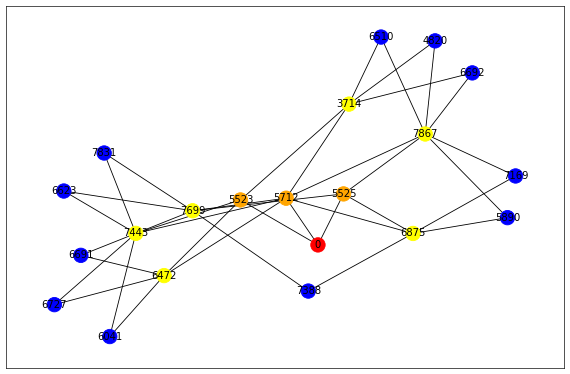

In [ ]:
color_map = []
G = nx.Graph()
G.add_edges_from(links)
fig = plt.figure(1, figsize=(12, 8), dpi=60)
nx.draw_networkx(G, node_color=color)

In [ ]:
new_syn_topo = pd.DataFrame()

for bs in layer:
  tmp_df = center_df_loc.loc[center_df_loc['bs'] == bs]
  tmp_df["layer"] = layer[bs]
  new_syn_topo = new_syn_topo.append(tmp_df, ignore_index = True)

core_loc = {"bs": "0", "lon": "111.085", "lat": "13.133056", "core_dist": "0", "layer": "0"}
new_syn_topo = new_syn_topo.append(core_loc, ignore_index = True)

fig = px.scatter(x=new_syn_topo['lon'], y=new_syn_topo['lat'], color = new_syn_topo['layer'], width=1000, height=700)
fig.update_traces(marker={'size': 15})

for l in links:
  if l[0] != 0:
    bs1 = new_syn_topo.loc[new_syn_topo['bs'] == l[0]]
  else:
    bs1 = {'lat': 13.133056, 'lon': 111.085}

  bs2 = new_syn_topo.loc[new_syn_topo['bs'] == l[1]]

  bs1_lat = float(bs1['lat'])
  bs1_lon = float(bs1['lon'])

  bs2_lat = float(bs2['lat'])
  bs2_lon = float(bs2['lon'])

  fig.add_shape(type="line", x0=bs1_lon, y0=bs1_lat,  x1=bs2_lon, y1=bs2_lat)

fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 30 CRs [11, 13, 6] | r = 0.5km

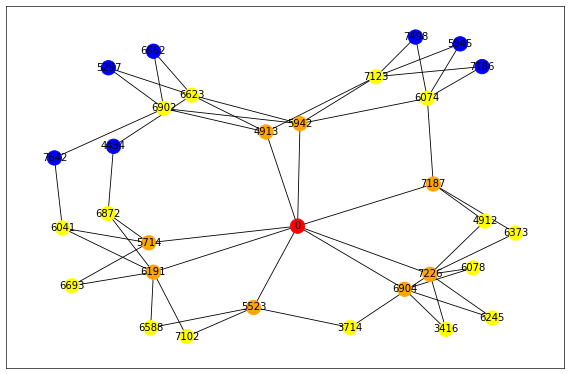

In [ ]:
color_map = []
G = nx.Graph()
G.add_edges_from(links)
fig = plt.figure(1, figsize=(12, 8), dpi=60)
nx.draw_networkx(G, node_color=color)

In [ ]:
new_syn_topo = pd.DataFrame()

for bs in layer:
  tmp_df = center_df_loc.loc[center_df_loc['bs'] == bs]
  tmp_df["layer"] = layer[bs]
  new_syn_topo = new_syn_topo.append(tmp_df, ignore_index = True)

core_loc = {"bs": "0", "lon": "111.085", "lat": "13.133056", "core_dist": "0", "layer": "0"}
new_syn_topo = new_syn_topo.append(core_loc, ignore_index = True)

fig = px.scatter(x=new_syn_topo['lon'], y=new_syn_topo['lat'], color = new_syn_topo['layer'], width=1000, height=700)
fig.update_traces(marker={'size': 15})

for l in links:
  if l[0] != 0:
    bs1 = new_syn_topo.loc[new_syn_topo['bs'] == l[0]]
  else:
    bs1 = {'lat': 13.133056, 'lon': 111.085}

  bs2 = new_syn_topo.loc[new_syn_topo['bs'] == l[1]]

  bs1_lat = float(bs1['lat'])
  bs1_lon = float(bs1['lon'])

  bs2_lat = float(bs2['lat'])
  bs2_lon = float(bs2['lon'])

  fig.add_shape(type="line", x0=bs1_lon, y0=bs1_lat,  x1=bs2_lon, y1=bs2_lat)

fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 50 CRs [19, 15, 16] | r = 1km

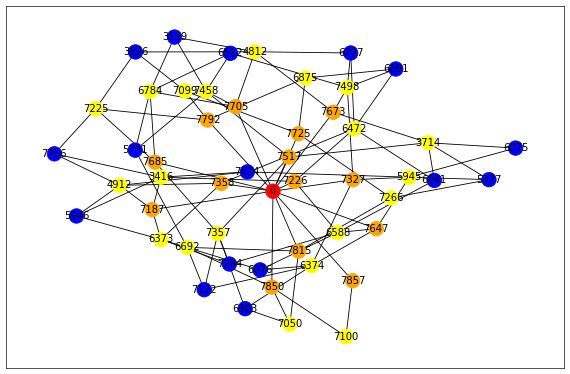

In [ ]:
color_map = []
G = nx.Graph()
G.add_edges_from(links)
fig = plt.figure(1, figsize=(12, 8), dpi=60)
nx.draw_networkx(G, node_color=color)

In [ ]:
new_syn_topo = pd.DataFrame()

for bs in layer:
  tmp_df = center_df_loc.loc[center_df_loc['bs'] == bs]
  tmp_df["layer"] = layer[bs]
  new_syn_topo = new_syn_topo.append(tmp_df, ignore_index = True)

core_loc = {"bs": "0", "lon": "111.085", "lat": "13.133056", "core_dist": "0", "layer": "0"}
new_syn_topo = new_syn_topo.append(core_loc, ignore_index = True)

fig = px.scatter(x=new_syn_topo['lon'], y=new_syn_topo['lat'], color = new_syn_topo['layer'], width=1000, height=700)
fig.update_traces(marker={'size': 15})

for l in links:
  if l[0] != 0:
    bs1 = new_syn_topo.loc[new_syn_topo['bs'] == l[0]]
  else:
    bs1 = {'lat': 13.133056, 'lon': 111.085}

  bs2 = new_syn_topo.loc[new_syn_topo['bs'] == l[1]]

  bs1_lat = float(bs1['lat'])
  bs1_lon = float(bs1['lon'])

  bs2_lat = float(bs2['lat'])
  bs2_lon = float(bs2['lon'])

  fig.add_shape(type="line", x0=bs1_lon, y0=bs1_lat,  x1=bs2_lon, y1=bs2_lat)

fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 100 CRs [2, 14, 84] | r = 1km

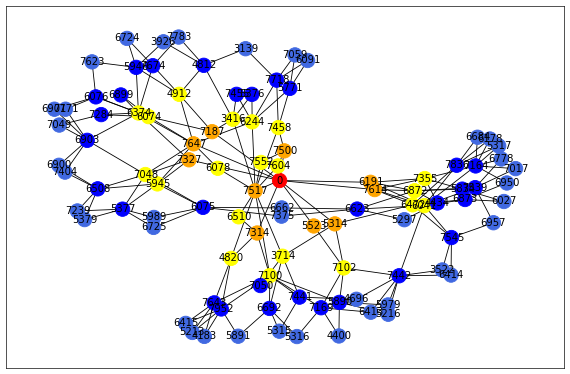

In [ ]:
color_map = []
G = nx.Graph()
G.add_edges_from(links)
fig = plt.figure(1, figsize=(12, 8), dpi=60)
nx.draw_networkx(G, node_color=color)

In [ ]:
new_syn_topo = pd.DataFrame()

for bs in layer:
  tmp_df = center_df_loc.loc[center_df_loc['bs'] == bs]
  tmp_df["layer"] = layer[bs]
  new_syn_topo = new_syn_topo.append(tmp_df, ignore_index = True)

core_loc = {"bs": "0", "lon": "111.085", "lat": "13.133056", "core_dist": "0", "layer": "0"}
new_syn_topo = new_syn_topo.append(core_loc, ignore_index = True)

fig = px.scatter(x=new_syn_topo['lon'], y=new_syn_topo['lat'], color = new_syn_topo['layer'], width=1000, height=700)
fig.update_traces(marker={'size': 15})

for l in links:
  if l[0] != 0:
    bs1 = new_syn_topo.loc[new_syn_topo['bs'] == l[0]]
  else:
    bs1 = {'lat': 13.133056, 'lon': 111.085}

  bs2 = new_syn_topo.loc[new_syn_topo['bs'] == l[1]]

  bs1_lat = float(bs1['lat'])
  bs1_lon = float(bs1['lon'])

  bs2_lat = float(bs2['lat'])
  bs2_lon = float(bs2['lon'])

  fig.add_shape(type="line", x0=bs1_lon, y0=bs1_lat,  x1=bs2_lon, y1=bs2_lat)

fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 200 CRs [3, 27, 170] | r = 1km

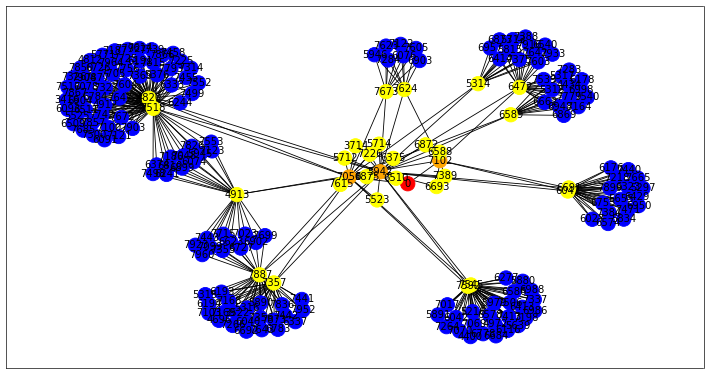

In [ ]:
color_map = []
G = nx.Graph()
G.add_edges_from(links)
fig = plt.figure(1, figsize=(12, 8), dpi=60)
nx.draw_networkx(G, node_color=color)

## 500 CRs [6, 67, 427] | r = 3km

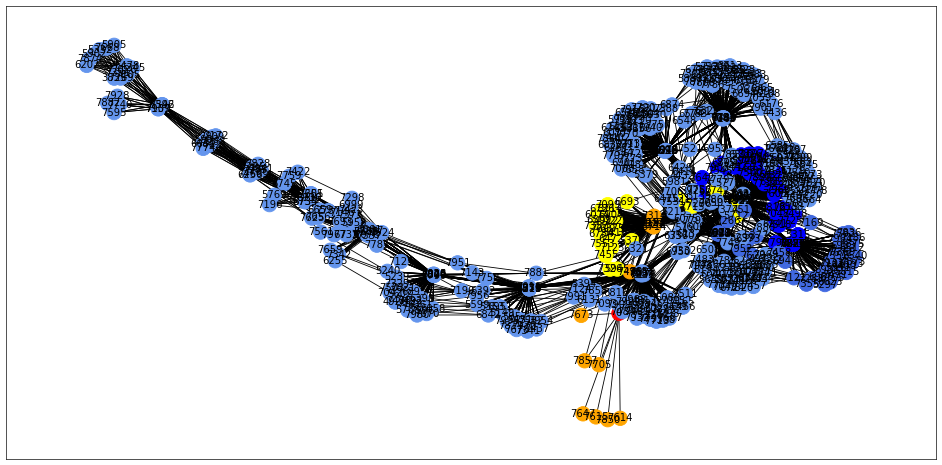

In [ ]:
import networkx as nx
color_map = []
G = nx.Graph()
G.add_edges_from(links)
fig = plt.figure(1, figsize=(20, 10), dpi=60)
nx.draw_networkx(G, node_color=color)

# Old code

In [ ]:
from random import choices
# INSIRA O NÓ CENTRAL DO GRAFO COMO CORE (MELHORAR)
core = 9
# total de nodes
n = 10

dist_mean = center_df_loc["core_dist"].mean()
dist_min = center_df_loc["core_dist"].min()
dist_max = center_df_loc["core_dist"].max()

#candidates

path = nx.all_pairs_shortest_path_length(G) # This is a generator
dpath = {x[0]:x[1] for x in path}

for i in range(0, n):
  k = dpath[core][i]
  print(k/(n/2))



0.8
0.2
0.6
0.2
0.2
0.6
0.4
0.8
0.4
0.0


[(0, 2), (1, 9), (2, 7), (2, 6), (3, 6), (3, 8), (3, 9), (4, 9), (5, 8)]

## Região 1 -- média variação

### Separando o Dataset

In [ ]:
reg_1_bs = []
for bs in syn_loc["bs"]:
  tmp_syn = syn_loc[syn_loc["bs"] == bs]
  lat = tmp_syn["lat"].values[0]
  lon = tmp_syn["lon"].values[0]
  if (110.980 < lon < 111.060) and (13.130 < lat < 13.210):
    reg_1_bs.append(tmp_syn["bs"].values[0])

print("Região 1 possui {} BSs".format(len(reg_1_bs)))
print(reg_1_bs)

Região 1 possui 435 BSs
[2493, 2844, 2845, 2847, 2852, 2857, 3444, 3450, 3480, 3493, 3618, 3666, 3963, 3972, 3975, 4124, 4350, 4353, 4366, 4367, 4369, 4387, 4388, 4460, 4464, 4488, 4489, 4562, 4564, 4640, 4642, 4645, 4649, 4652, 4653, 4657, 4660, 4661, 4672, 4673, 4736, 4745, 4746, 4749, 4753, 4754, 4755, 4768, 4771, 4773, 4774, 4857, 4862, 4920, 4930, 4934, 4936, 4938, 4941, 4951, 4954, 4955, 4956, 4957, 4958, 5020, 5021, 5023, 5027, 5029, 5030, 5031, 5032, 5035, 5051, 5121, 5175, 5176, 5183, 5184, 5185, 5188, 5190, 5192, 5194, 5195, 5196, 5202, 5262, 5263, 5264, 5277, 5279, 5335, 5390, 5395, 5396, 5401, 5402, 5404, 5407, 5409, 5410, 5411, 5419, 5471, 5473, 5479, 5487, 5550, 5555, 5596, 5597, 5598, 5603, 5605, 5610, 5611, 5613, 5614, 5615, 5616, 5617, 5618, 5619, 5627, 5628, 5665, 5666, 5667, 5668, 5669, 5671, 5673, 5686, 5727, 5729, 5764, 5766, 5767, 5775, 5777, 5778, 5779, 5781, 5782, 5783, 5786, 5801, 5851, 5852, 5853, 5855, 5861, 5863, 5910, 5949, 5950, 5951, 5952, 5954, 5959, 596

In [ ]:
reg_1_df_loc = pd.DataFrame()
for bs in reg_1_bs:
  tmp_syn = syn_loc[syn_loc["bs"] == bs]
  reg_1_df_loc = pd.concat([reg_1_df_loc, tmp_syn])

In [ ]:
reg_1_df = pd.DataFrame()
for bs in reg_1_bs:
  tmp_syn = syn_df[syn_df["bs"] == bs]
  reg_1_df = pd.concat([reg_1_df, tmp_syn])

In [ ]:
# Diferença
user_dif = {}

for bs in reg_1_df_loc['bs']:
  user_dif[bs] = reg_1_df[reg_1_df['bs'] == bs]['users'].max() - reg_1_df[reg_1_df['bs'] == bs]['users'].min()

print(user_dif)

{2493: 3, 2844: 5, 2845: 4, 2847: 3, 2852: 4, 2857: 16, 3444: 11, 3450: 7, 3480: 5, 3493: 9, 3618: 10, 3666: 14, 3963: 5, 3972: 5, 3975: 6, 4124: 12, 4350: 4, 4353: 7, 4366: 6, 4367: 5, 4369: 36, 4387: 5, 4388: 5, 4460: 9, 4464: 5, 4488: 6, 4489: 14, 4562: 7, 4564: 6, 4640: 7, 4642: 5, 4645: 7, 4649: 5, 4652: 7, 4653: 7, 4657: 19, 4660: 9, 4661: 5, 4672: 7, 4673: 20, 4736: 11, 4745: 14, 4746: 5, 4749: 5, 4753: 5, 4754: 6, 4755: 7, 4768: 5, 4771: 14, 4773: 5, 4774: 8, 4857: 11, 4862: 4, 4920: 7, 4930: 7, 4934: 4, 4936: 7, 4938: 4, 4941: 11, 4951: 7, 4954: 8, 4955: 5, 4956: 8, 4957: 7, 4958: 11, 5020: 6, 5021: 4, 5023: 14, 5027: 5, 5029: 10, 5030: 17, 5031: 4, 5032: 5, 5035: 4, 5051: 33, 5121: 7, 5175: 3, 5176: 4, 5183: 7, 5184: 10, 5185: 7, 5188: 11, 5190: 13, 5192: 2, 5194: 19, 5195: 6, 5196: 8, 5202: 19, 5262: 10, 5263: 5, 5264: 6, 5277: 4, 5279: 5, 5335: 34, 5390: 12, 5395: 4, 5396: 8, 5401: 5, 5402: 7, 5404: 9, 5407: 6, 5409: 17, 5410: 6, 5411: 7, 5419: 9, 5471: 10, 5473: 14, 5479: 

### Plotando região de acordo com a diferença e o consumo de cada BS

In [ ]:
import plotly.express as px

for bs in reg_1_df_loc['bs']:
  tmp_df = reg_1_df_loc.loc[syn_loc['bs'] == bs]

fig = px.scatter(x=reg_1_df_loc['lon'], y=reg_1_df_loc['lat'], color = list(user_dif.values()), width=1000, height=700)
fig.show()

In [ ]:
pd.options.plotting.backend = "plotly"
reg_1_df["users"].plot.line()

## Região 2 -- menor variação

### Separando o Dataset

In [ ]:
reg_2_bs = []
for bs in syn_loc["bs"]:
  tmp_syn = syn_loc[syn_loc["bs"] == bs]
  lat = tmp_syn["lat"].values[0]
  lon = tmp_syn["lon"].values[0]
  if (111.110 < lon < 111.250) and (13.130 < lat < 13.270):
    reg_2_bs.append(tmp_syn["bs"].values[0])

print("Região 1 possui {} BSs".format(len(reg_2_bs)))
print(reg_2_bs)

Região 1 possui 232 BSs
[906, 3053, 3281, 3282, 3286, 3484, 3657, 3828, 3889, 3890, 4118, 4155, 4156, 4171, 4226, 4227, 4228, 4233, 4373, 4375, 4477, 4480, 4500, 4501, 4509, 4545, 4570, 4573, 4601, 4606, 4617, 4764, 4798, 4805, 4806, 4843, 4846, 4868, 4887, 4900, 5065, 5066, 5067, 5071, 5072, 5088, 5112, 5113, 5115, 5131, 5152, 5198, 5273, 5288, 5293, 5326, 5339, 5342, 5362, 5413, 5481, 5485, 5500, 5501, 5502, 5503, 5513, 5540, 5543, 5557, 5562, 5577, 5580, 5621, 5659, 5684, 5696, 5698, 5699, 5704, 5705, 5706, 5733, 5789, 5790, 5791, 5793, 5794, 5857, 5860, 5871, 5876, 5882, 5913, 5930, 5937, 5969, 6011, 6024, 6026, 6034, 6044, 6057, 6063, 6065, 6068, 6106, 6108, 6173, 6180, 6181, 6183, 6200, 6214, 6233, 6316, 6320, 6326, 6327, 6328, 6341, 6342, 6343, 6352, 6403, 6404, 6405, 6460, 6462, 6468, 6469, 6474, 6475, 6500, 6502, 6529, 6530, 6531, 6532, 6568, 6569, 6570, 6592, 6593, 6594, 6601, 6602, 6642, 6643, 6675, 6679, 6680, 6685, 6703, 6704, 6741, 6773, 6774, 6775, 6776, 6777, 6787, 6800

In [ ]:
reg_2_df_loc = pd.DataFrame()
for bs in reg_2_bs:
  tmp_syn = syn_loc[syn_loc["bs"] == bs]
  reg_2_df_loc = pd.concat([reg_2_df_loc, tmp_syn])

In [ ]:
reg_2_df = pd.DataFrame()
for bs in reg_2_bs:
  tmp_syn = syn_df[syn_df["bs"] == bs]
  reg_2_df = pd.concat([reg_2_df, tmp_syn])

In [ ]:
# Diferença
user_dif = {}

for bs in reg_2_df_loc['bs']:
  user_dif[bs] = reg_2_df[reg_2_df['bs'] == bs]['users'].max() - reg_2_df[reg_2_df['bs'] == bs]['users'].min()

print(user_dif)

{906: 4, 3053: 5, 3281: 3, 3282: 3, 3286: 2, 3484: 3, 3657: 4, 3828: 3, 3889: 3, 3890: 6, 4118: 5, 4155: 8, 4156: 2, 4171: 5, 4226: 3, 4227: 9, 4228: 6, 4233: 4, 4373: 5, 4375: 4, 4477: 15, 4480: 3, 4500: 5, 4501: 3, 4509: 3, 4545: 5, 4570: 7, 4573: 5, 4601: 5, 4606: 6, 4617: 3, 4764: 3, 4798: 5, 4805: 2, 4806: 4, 4843: 4, 4846: 5, 4868: 6, 4887: 20, 4900: 3, 5065: 6, 5066: 4, 5067: 4, 5071: 9, 5072: 5, 5088: 8, 5112: 5, 5113: 11, 5115: 4, 5131: 5, 5152: 9, 5198: 9, 5273: 5, 5288: 17, 5293: 5, 5326: 6, 5339: 4, 5342: 4, 5362: 8, 5413: 8, 5481: 8, 5485: 4, 5500: 13, 5501: 14, 5502: 29, 5503: 4, 5513: 7, 5540: 23, 5543: 6, 5557: 5, 5562: 8, 5577: 11, 5580: 16, 5621: 4, 5659: 5, 5684: 5, 5696: 3, 5698: 5, 5699: 6, 5704: 5, 5705: 7, 5706: 5, 5733: 4, 5789: 15, 5790: 11, 5791: 6, 5793: 8, 5794: 3, 5857: 9, 5860: 6, 5871: 21, 5876: 5, 5882: 15, 5913: 4, 5930: 15, 5937: 13, 5969: 5, 6011: 4, 6024: 8, 6026: 7, 6034: 3, 6044: 5, 6057: 7, 6063: 6, 6065: 28, 6068: 10, 6106: 15, 6108: 18, 6173: 8,

### Plotando região de acordo com a diferença e o consumo de cada BS

In [ ]:
import plotly.express as px

for bs in reg_2_df_loc['bs']:
  tmp_df = reg_2_df_loc.loc[syn_loc['bs'] == bs]

fig = px.scatter(x=reg_2_df_loc['lon'], y=reg_2_df_loc['lat'], color = list(user_dif.values()), width=1000, height=700)
fig.show()

In [ ]:
pd.options.plotting.backend = "plotly"
reg_2_df["users"].plot.line()

# Todas as regiões (anteriormente)


In [ ]:
import plotly.express as px
all_color = []

for bs in syn_loc['bs']:
  tmp_df = syn_loc.loc[syn_loc['bs'] == bs]

  if bs in center_bs:
    all_color.append(1)
  elif bs in reg_1_bs:
    all_color.append(2)
  elif bs in reg_2_bs:
    all_color.append(3)
  else:
    all_color.append(0)


fig = px.scatter(x=syn_loc['lon'], y=syn_loc['lat'], color = all_color, width=1000, height=700)
fig.show()

In [ ]:
color1 = [1 for bs in center_bs]
color2 = [2 for bs in reg_1_bs]
color3 = [3 for bs in reg_2_bs]
all_color = color1 + color2 + color3
print(len(all_color))
all_reg = pd.concat([center_df_loc, reg_1_df_loc, reg_2_df_loc])
all_reg.plot.scatter(x=all_reg["lat"], y=all_reg["lon"], color=all_color, width=1000, height=700)

1303
